In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from desiutil.log import get_logger, DEBUG
log = get_logger()

import seaborn as sns
sns.set(style='white', font_scale=1.1, palette='Set2')
%matplotlib inline

In [2]:
healpixel = 26030
nside = 64
seed = 555
rand = np.random.RandomState(seed)

In [3]:
from desitarget.mock.mockmaker import BGSMaker

In [4]:
from desisim.templates import BGS
def _default_wave(wavemin=None, wavemax=None, dw=0.2):
    """Generate a default wavelength vector for the output spectra."""
    from desimodel.io import load_throughput
    
    if wavemin is None:
        wavemin = load_throughput('b').wavemin - 10.0
    if wavemax is None:
        wavemax = load_throughput('z').wavemax + 10.0
            
    return np.arange(round(wavemin, 1), wavemax, dw)

In [26]:
# Plotting Function
def plot_subset(wave, flux, truth, objtruth, nplot=16, ncol=4, these=None, 
                xlim=None, loc='right', targname='', objtype=''):
    """Plot a random sampling of spectra."""
    
    nspec, npix = flux.shape
    if nspec < nplot:
        nplot = nspec
    
    nrow = np.ceil(nplot / ncol).astype('int')

    if loc == 'left':
        xtxt, ytxt, ha = 0.05, 0.93, 'left'
    else:
        xtxt, ytxt, ha = 0.93, 0.93, 'right'
    
    if these is None:
        these = rand.choice(nspec, nplot, replace=False)
        these = np.sort(these)
        
    ww = (wave > 5500) * (wave < 5550)

    fig, ax = plt.subplots(nrow, ncol, figsize=(2.5*ncol, 2*nrow), sharey=False, sharex=True)
    for thisax, indx in zip(ax.flat, these):
        thisax.plot(wave, flux[indx, :] / np.median(flux[indx, ww]))
        if objtype == 'STAR' or objtype == 'WD':
            thisax.text(xtxt, ytxt, r'$T_{{eff}}$={:.0f} K'.format(objtruth['TEFF'][indx]), 
                        ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
        else:
            if 'SNE_FLUXRATIO' in truth.columns:
                thisax.text(xtxt, ytxt, 'z={:.3f} \n snr={:.3f}'.format(truth['TRUEZ'][indx],truth['SNE_FLUXRATIO'][indx]), 
                            ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
            else:
                thisax.text(xtxt, ytxt, 'z={:.3f}'.format(truth['TRUEZ'][indx]), 
                            ha=ha, va='top', transform=thisax.transAxes, fontsize=13)
            
        thisax.xaxis.set_major_locator(plt.MaxNLocator(3))
        if xlim:
            thisax.set_xlim(xlim)
    for thisax in ax.flat:
        thisax.yaxis.set_ticks([])
        thisax.margins(0.2)
        
    fig.suptitle(targname)
    fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.93)
    
def demo_mockmaker(Maker, seed=None, nrand=16,add_SNeIa=False, loc='right',plot=True):

    TARGET = Maker(seed=seed)
    # This is the important part
    # Passing a BGS template instance with add_SNeIa 
    TARGET.template_maker = BGS(add_SNeIa=add_SNeIa,wave=_default_wave())
    ##############################################################################3
    log.info('Reading the mock catalog for {}s'.format(TARGET.objtype))
    tdata = TARGET.read(healpixels=healpixel, nside=nside)
    tdata['sne_fluxratiorange'] = (0.01,1)
    tdata['sne_filter'] = 'decam2014-r'
    
    log.info('Generating {} random spectra.'.format(nrand))
    indx = rand.choice(len(tdata['RA']), np.min( (nrand, len(tdata['RA'])) ) )
    tflux, twave, ttargets, ttruth, tobjtruth = TARGET.make_spectra(tdata, indx=indx)
    
    log.info('Selecting targets')
    TARGET.select_targets(ttargets, ttruth)
    if plot:
        plot_subset(twave, tflux, ttruth, tobjtruth, loc=loc, 
                    targname=tdata['TARGET_NAME'], objtype=TARGET.objtype)

    return tflux, twave, ttargets, ttruth, tobjtruth

In [59]:
tflux, twave, ttargets, ttruth, tobjtruth = demo_mockmaker(BGSMaker,add_SNeIa=True,plot=False)

INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/bgs_templates_v2.2.fits
INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/sne_templates_v1.1.fits
INFO:<ipython-input-26-c4a51414cd3f>:54:demo_mockmaker: Reading the mock catalog for BGSs
INFO:mockmaker.py:1975:readmock: Using cached coordinates, healpixels, and pixel weights from /home/c-m/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS.hdf5
INFO:mockmaker.py:1992:readmock: Trimmed to 2338 BGSs in 1 healpixel(s).
INFO:mockmaker.py:2033:readmock: Sampling from BGS Gaussian mixture model.
INFO:<ipython-input-26-c4a51414cd3f>:59:demo_mockmaker: Generating 16 random spectra.


/home/c-m/Software/anaconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


INFO:<ipython-input-26-c4a51414cd3f>:63:demo_mockmaker: Selecting targets


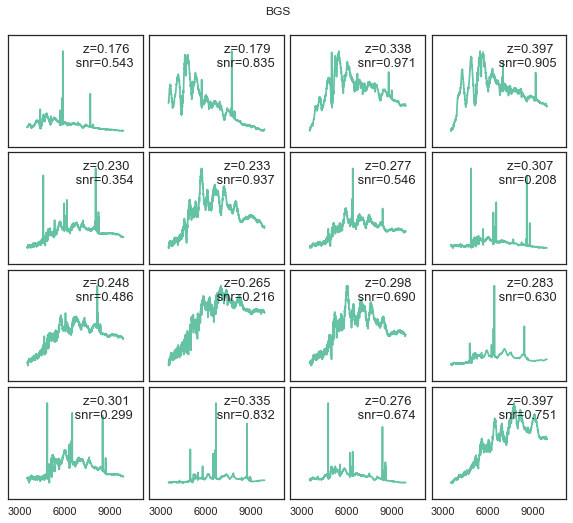

In [29]:
plot_subset(twave, tflux, ttruth, tobjtruth, loc='right', 
                    targname='BGS', objtype='BGS')

INFO:io.py:955:read_basis_templates: Reading /home/c-m/desi/spectro/templates/basis_templates/v3.0/bgs_templates_v2.2.fits
INFO:<ipython-input-26-c4a51414cd3f>:54:demo_mockmaker: Reading the mock catalog for BGSs
INFO:mockmaker.py:1975:readmock: Using cached coordinates, healpixels, and pixel weights from /home/c-m/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS.hdf5
INFO:mockmaker.py:1992:readmock: Trimmed to 2338 BGSs in 1 healpixel(s).
INFO:mockmaker.py:2033:readmock: Sampling from BGS Gaussian mixture model.
INFO:<ipython-input-26-c4a51414cd3f>:59:demo_mockmaker: Generating 16 random spectra.


/home/c-m/Software/anaconda3/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


INFO:<ipython-input-26-c4a51414cd3f>:63:demo_mockmaker: Selecting targets


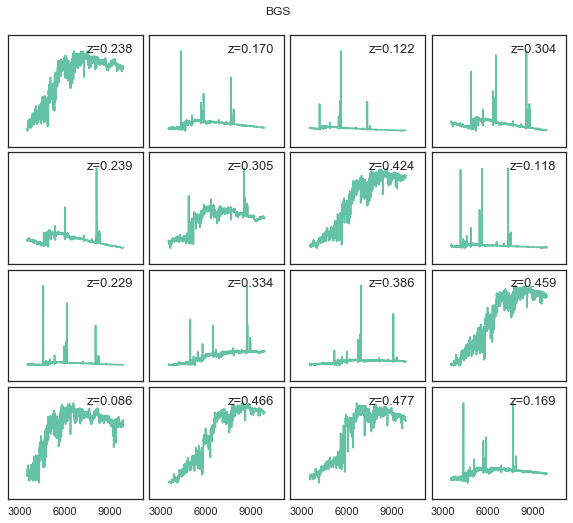

In [31]:
tflux, twave, ttargets, ttruth, tobjtruth = demo_mockmaker(BGSMaker,add_SNeIa=False,plot=True)